# Análisis sismológico básico

In [1]:
from obspy.core import read

## Trigger

In [4]:
st = read("https://examples.obspy.org/ev0_6.a01.gse2")

In [5]:
st = st.select(component="Z")

In [6]:
print(st)

1 Trace(s) in Stream:
.EV0_6..EHZ | 1970-01-01T01:00:00.000000Z - 1970-01-01T01:00:59.995000Z | 200.0 Hz, 12000 samples


In [7]:
tr = st[0]

In [8]:
print(tr.stats)

         network: 
         station: EV0_6
        location: 
         channel: EHZ
       starttime: 1970-01-01T01:00:00.000000Z
         endtime: 1970-01-01T01:00:59.995000Z
   sampling_rate: 200.0
           delta: 0.005
            npts: 12000
           calib: 1.0
         _format: GSE2
            gse2: AttribDict({'auxid': '', 'datatype': 'CM6', 'calper': 1.0, 'instype': '', 'hang': 0.0, 'vang': -1.0})


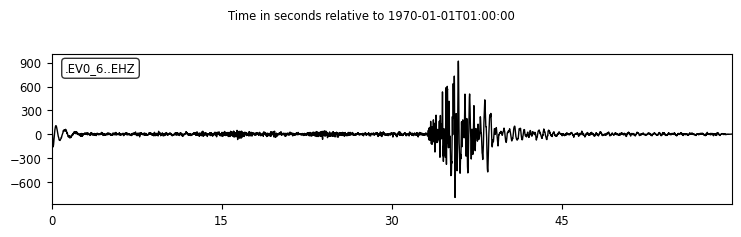

In [9]:
trace_relative = tr.plot(type="relative")

Classic STA/LTA

In [13]:
from obspy.signal.trigger import classic_sta_lta
from obspy.signal.trigger import plot_trigger

In [9]:
help(classic_sta_lta)

Help on function classic_sta_lta in module obspy.signal.trigger:

classic_sta_lta(a, nsta, nlta)
    Computes the standard STA/LTA from a given input array a. The length of
    the STA is given by nsta in samples, respectively is the length of the
    LTA given by nlta in samples.
    
    Fast version written in C.
    
    :type a: NumPy :class:`~numpy.ndarray`
    :param a: Seismic Trace
    :type nsta: int
    :param nsta: Length of short time average window in samples
    :type nlta: int
    :param nlta: Length of long time average window in samples
    :rtype: NumPy :class:`~numpy.ndarray`
    :return: Characteristic function of classic STA/LTA



In [10]:
df = tr.stats.sampling_rate

In [13]:
cft = classic_sta_lta(tr.data, int(5 * df), int(10 * df))

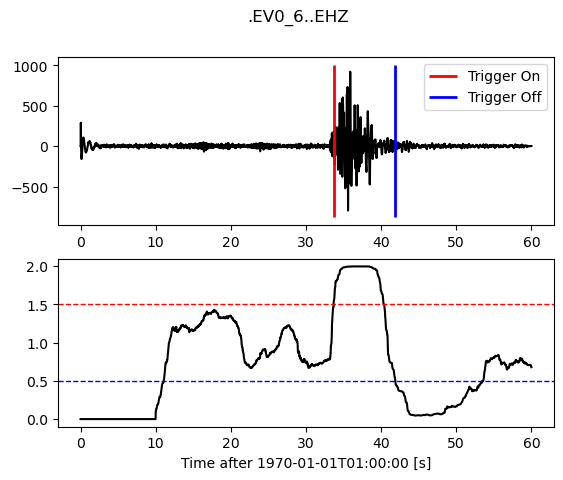

In [14]:
plot_trigger(tr, cft, 1.5, 0.5)

Detección - Z

In [2]:
from obspy.signal.trigger import z_detect

In [11]:
cft = z_detect(tr.data, int(10 * df))

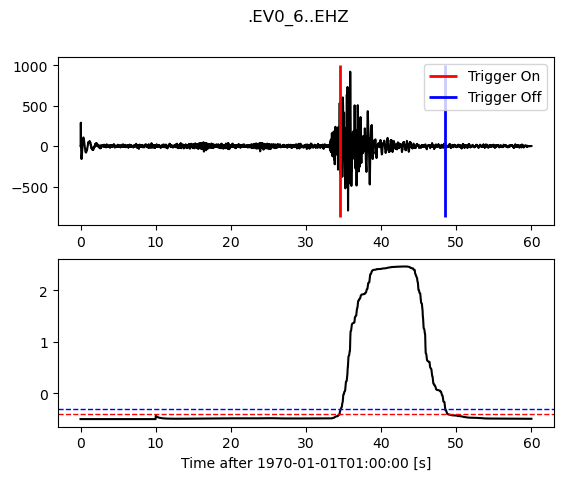

In [17]:
plot_trigger(tr, cft, -0.4, -0.3)

STA/LTA Recursivo

In [18]:
from obspy.signal.trigger import recursive_sta_lta

In [19]:
cft = recursive_sta_lta(tr.data, int(5 * df), int(10 * df))

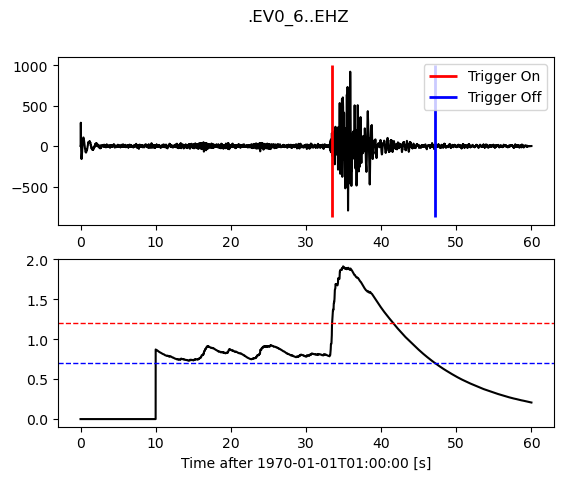

In [21]:
plot_trigger(tr, cft, 1.2, 0.7)

Carl-STA-Trig:

In [22]:
from obspy.signal.trigger import carl_sta_trig

In [23]:
cft = carl_sta_trig(tr.data, int(5 * df), int(10 * df), 0.8, 0.8)

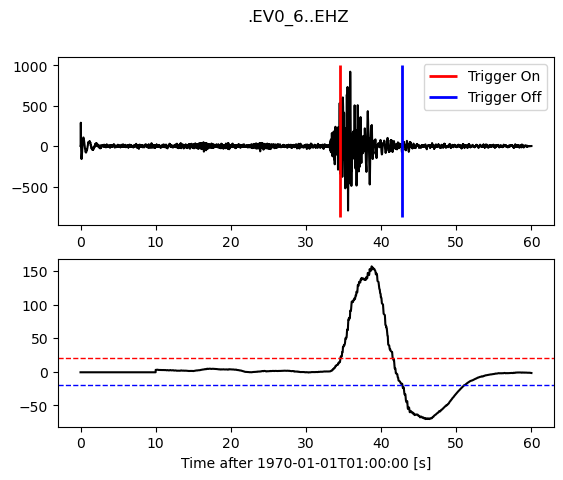

In [25]:
plot_trigger(tr, cft, 20, -20)

Delayed STA/LTA

In [26]:
from obspy.signal.trigger import delayed_sta_lta

In [27]:
cft = delayed_sta_lta(tr.data, int(5 * df), int(10 * df))

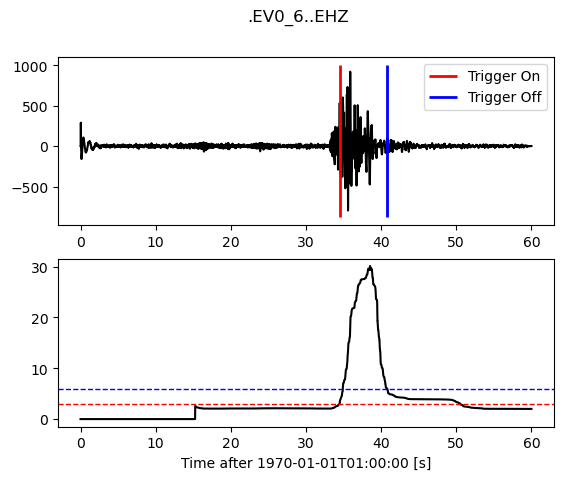

In [29]:
plot_trigger(tr, cft, 3, 6)

## Picker

In [30]:
from obspy.signal.trigger import pk_baer

In [31]:
trace = read("https://examples.obspy.org/ev0_6.a01.gse2")[0]

In [33]:
df = trace.stats.sampling_rate

In [34]:
p_pick, phase_info = pk_baer(trace.data, df, 20, 60, 7, 12, 100, 100)

In [35]:
print(p_pick, phase_info)

6894 EPU3


In [36]:
print(p_pick/df)

34.47
